<a href="https://colab.research.google.com/github/S2ONe3/Handwriting-Recognition-Model/blob/main/Handwritting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **mount google drive to colab**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
#  unzip data folder for admin 
!unzip gdrive/My\ Drive/Colab\ Notebooks/archive.zip > /dev/null

#unzip data folder for other team_mates
# !unzip gdrive/My\ Drive/archive.zip > /dev/null


**importing modules** 

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

In [ ]:
train = pd.read_csv('/content/written_name_train_v2.csv')
valid = pd.read_csv('/content/written_name_validation_v2.csv')

**Print number of NaN datas**


In [ ]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  565
Number of NaNs in validation set :  78


**drop all NaN datas**


In [ ]:
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)

**trim both dataset 'train' and 'valid' excluding the images which are unreadable**

In [ ]:
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

**Print number of READABLE datas in both data_set**

In [ ]:
print("Number of READABLE in train set      : ", len(train))
print("Number of READABLE in validation set : ", len(valid))

Number of READABLE in train set      :  330294
Number of READABLE in validation set :  41280


**bring all text datas in one format**

In [ ]:
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()

In [ ]:
train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)

**preprocess function do crop or padding using white pixels on any data_image**


In [ ]:
def preprocess(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255 # blank white image
    
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [ ]:
train_size_short = 330294
train_size = 15000
valid_size = 15000
# train_size = 1000
# valid_size = 300

(-0.5, 323.5, 43.5, -0.5)

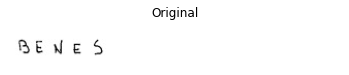

In [ ]:
img_dir = '/content/train_v2/train/TRAIN_00003.jpg'
image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap = 'gray') # colormap instance or registered colormap name
plt.title('Original', fontsize=12)
plt.axis('off')


**Preprocess all Train Data Images**



In [ ]:
# def loop(batch_i= 1,batch_f=1000):
def loop(batch_i,batch_f):
  train_edited_local = []
  for i in range(batch_i,batch_f):
      img_dir = '/content/train_v2/train/' + train.loc[i, 'FILENAME']
      image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
      image = preprocess(image)
      image = image/255.
      train_edited_local.append(image)
  # print(train_edited_local)
  return train_edited_local

# print(loop(batch_i= 1,batch_f=1000))

In [ ]:
train_edited = []

#Creating Batch for Better Utilization of Ram
batch_i=0 
batch_f=1000
stop=True

while(stop):
  train_edited.extend(loop(batch_i,batch_f))
  if(stop):
      batch_i = batch_f
      batch_f += 1000
      if(train_size < batch_f):
        batch_f = train_size
        stop = False

**Preprocess all Valid Data Images**

In [ ]:
valid_edited = []

# #Creating Batch for Better Utilization of Ram
# batch_i=0 
# batch_f=1000
# stop=True

for i in range(0,valid_size):
    img_dir = '/content/validation_v2/validation/' + valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_edited.append(image)
    # if(stop):
    #   batch_i = batch_f
    #   batch_f *= 2
    #   if(valid_size < batch_f):
    #     batch_f = valid_size
    #     stop = False

(-0.5, 63.5, 255.5, -0.5)

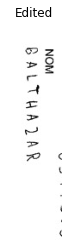

In [ ]:
image = preprocess(image)
image = image/255
plt.imshow(train_edited[0], cmap = 'gray') # colormap instance or registered colormap name
plt.title('Edited', fontsize=12)
plt.axis('off')

**Reshaping all Preprocessed Data Images**

In [ ]:
train_edited = np.array(train_edited).reshape(-1, 256, 64, 1)
valid_edited = np.array(valid_edited).reshape(-1, 256, 64, 1)

**Calculating CTC loss**

In [ ]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 34 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    label_string = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            label_string += alphabets[ch]
    return label_string

**Printing A Sample Case**

In [ ]:
name = 'JOKERK'
num = label_to_num(name)
print(name, '\t',num)
print()
print(num, '\t', num_to_label(num))

JOKERK 	 [ 9 14 10  4 17 10]

[ 9 14 10  4 17 10] 	 JOKERK


**CTC LOSS LABELS**

In [ ]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])    

In [ ]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])  

In [ ]:
print('True label : ',train.loc[100, 'IDENTITY'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100], 
      '\ntrain_input_len : ', train_input_len[100])

True label :  NOUR 
train_y :  [13. 14. 20. 17. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.] 
train_label_len :  [4.] 
train_input_len :  [62.]


**The CNN Model**

In [ ]:
#  use for testing purpose
input_data = Input(shape=(256, 64, 1), name='input')
print(input_data)

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 64, 1), dtype=tf.float32, name='input'), name='input', description="created by layer 'input'")


In [ ]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 256, 64, 32)       320       
                                                                 
 batch_normalization (BatchN  (None, 256, 64, 32)      128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 64, 32)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 128, 32, 32)       0         
                                                                 
 conv2 (Conv2D)              (None, 128, 32, 64)       18496     
                                                             

In [ ]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [ ]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [ ]:
# print(train_edited)
print(len(train_edited))
del train
del valid

15000


In [ ]:
import gc 
gc.collect()

20091

In [ ]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))

model_final.fit(x=[train_edited, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_edited, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=60, batch_size=128)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/60
118/118 [==============================] - 56s 316ms/step - loss: 29.4591 - val_loss: 25.2579
Epoch 2/60
118/118 [==============================] - 33s 281ms/step - loss: 20.4772 - val_loss: 20.7483
Epoch 3/60
118/118 [==============================] - 34s 290ms/step - loss: 20.2105 - val_loss: 20.3287
Epoch 4/60
118/118 [==============================] - 33s 283ms/step - loss: 20.0514 - val_loss: 20.1783
Epoch 5/60
118/118 [==============================] - 33s 283ms/step - loss: 19.8797 - val_loss: 20.0040
Epoch 6/60
118/118 [==============================] - 33s 282ms/step - loss: 19.6761 - val_loss: 19.6534
Epoch 7/60
118/118 [==============================] - 33s 280ms/step - loss: 19.3446 - val_loss: 19.3153
Epoch 8/60
118/118 [==============================] - 35s 300ms/step - loss: 18.8494 - val_loss: 19.0975
Epoch 9/60
118/118 [==============================] - 33s 280ms/step - loss: 18.2629 - val_loss: 18.6819
Epoch 10/60
118/118 [==============================] - 

In [ ]:
preds = model.predict(valid_edited)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

In [ ]:
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 1.89%
Correct words predicted      : 0.00%


In [ ]:
del train_edited
del valid_edited

[[10  4 21  8 13 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
[[ 2 14 14 19 20 24 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
[[11  4 13  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
[[ 9 20 11  4 18 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
[[ 2  7  4 17 15  8 13 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


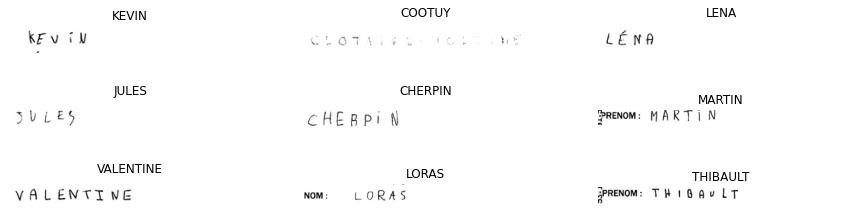

In [ ]:
test = pd.read_csv('/content/written_name_test_v2.csv')

plt.figure(figsize=(15, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    img_dir = '/content/test_v2/test/'+test.loc[i, 'FILENAME']
    # img_dir = '/content/'+str(i)+".jpg"
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    print(decoded)
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)
